## Example 3: Hierarchical model

Import libraries

In [1]:
from glob import glob
from os.path import basename
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use('arviz-darkgrid')
np.random.seed(1234)
pd.options.mode.chained_assignment = None

Read the data.

In [3]:
DL_PATH = 'data/facial_feedback/*csv'

dfs = []
columns = ['subject', 'cond_id', 'condition', 'correct_c1', 'correct_c2', 'correct_c3', 'correct_c4',
           'correct_total', 'rating_t1', 'rating_t2', 'rating_c1', 'rating_c2', 'rating_c3',
           'rating_c4', 'self_perf', 'comprehension', 'awareness', 'transcript', 'age', 'gender',
           'student', 'occupation']

count = 0
for idx, study in enumerate(glob(DL_PATH)):
    data = pd.read_csv(study, encoding='latin1', skiprows=2, header=None, index_col=False).iloc[:, :22]
    data.columns = columns
    # Add study name
    data['study'] = idx
    # Some sites used the same subject id numbering schemes, so prepend with study to create unique ids.
    # Note that if we don't do this, Bambi would have no way of distinguishing two subjects who share
    # the same id, which would hose our results.
    data['uid'] = data['subject'].astype(float) + count
    dfs.append(data)
data = pd.concat(dfs, axis=0).apply(pd.to_numeric,  errors='coerce', axis=1)

Reshape data

In [4]:
# Keep only subjects who (i) respond appropriately on all trials,
# (ii) understand the cartoons, and (iii) don't report any awareness
# of the hypothesis or underlying theory.
valid = data.query('correct_total==4 and comprehension==1 and awareness==0')
long = pd.melt(valid, ['uid', 'condition', 'gender', 'age', 'study', 'self_perf'],
               ['rating_c1', 'rating_c2', 'rating_c3', 'rating_c4'], var_name='stimulus')

Fit the model

In [5]:
# Initialize the model, passing in the dataset we want to use.
model = bmb.Model(long, dropna=True)

# Set a custom prior on group specific factor variances—just for illustration
group_specific_sd = bmb.Prior('HalfNormal', sigma=10)
group_specific_prior = bmb.Prior('Normal', mu=0, sigma=group_specific_sd)
model.set_priors(group_specific=group_specific_prior)

# Note we use 2000 samples for tuning and increase the taget_accept to 0.99. 
# The default values result in many divergences.
results = model.fit(
    'value ~ condition + age + gender + (1|uid) + (condition|study) + (condition|stimulus)',
    draws=1000, tune=2000, target_accept=0.99
)

Automatically removing 33/6940 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [value_sigma, condition|stimulus_offset, condition|stimulus_sigma, 1|stimulus_offset, 1|stimulus_sigma, condition|study_offset, condition|study_sigma, 1|study_offset, 1|study_sigma, 1|uid_offset, 1|uid_sigma, gender, age, condition, Intercept]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1307 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


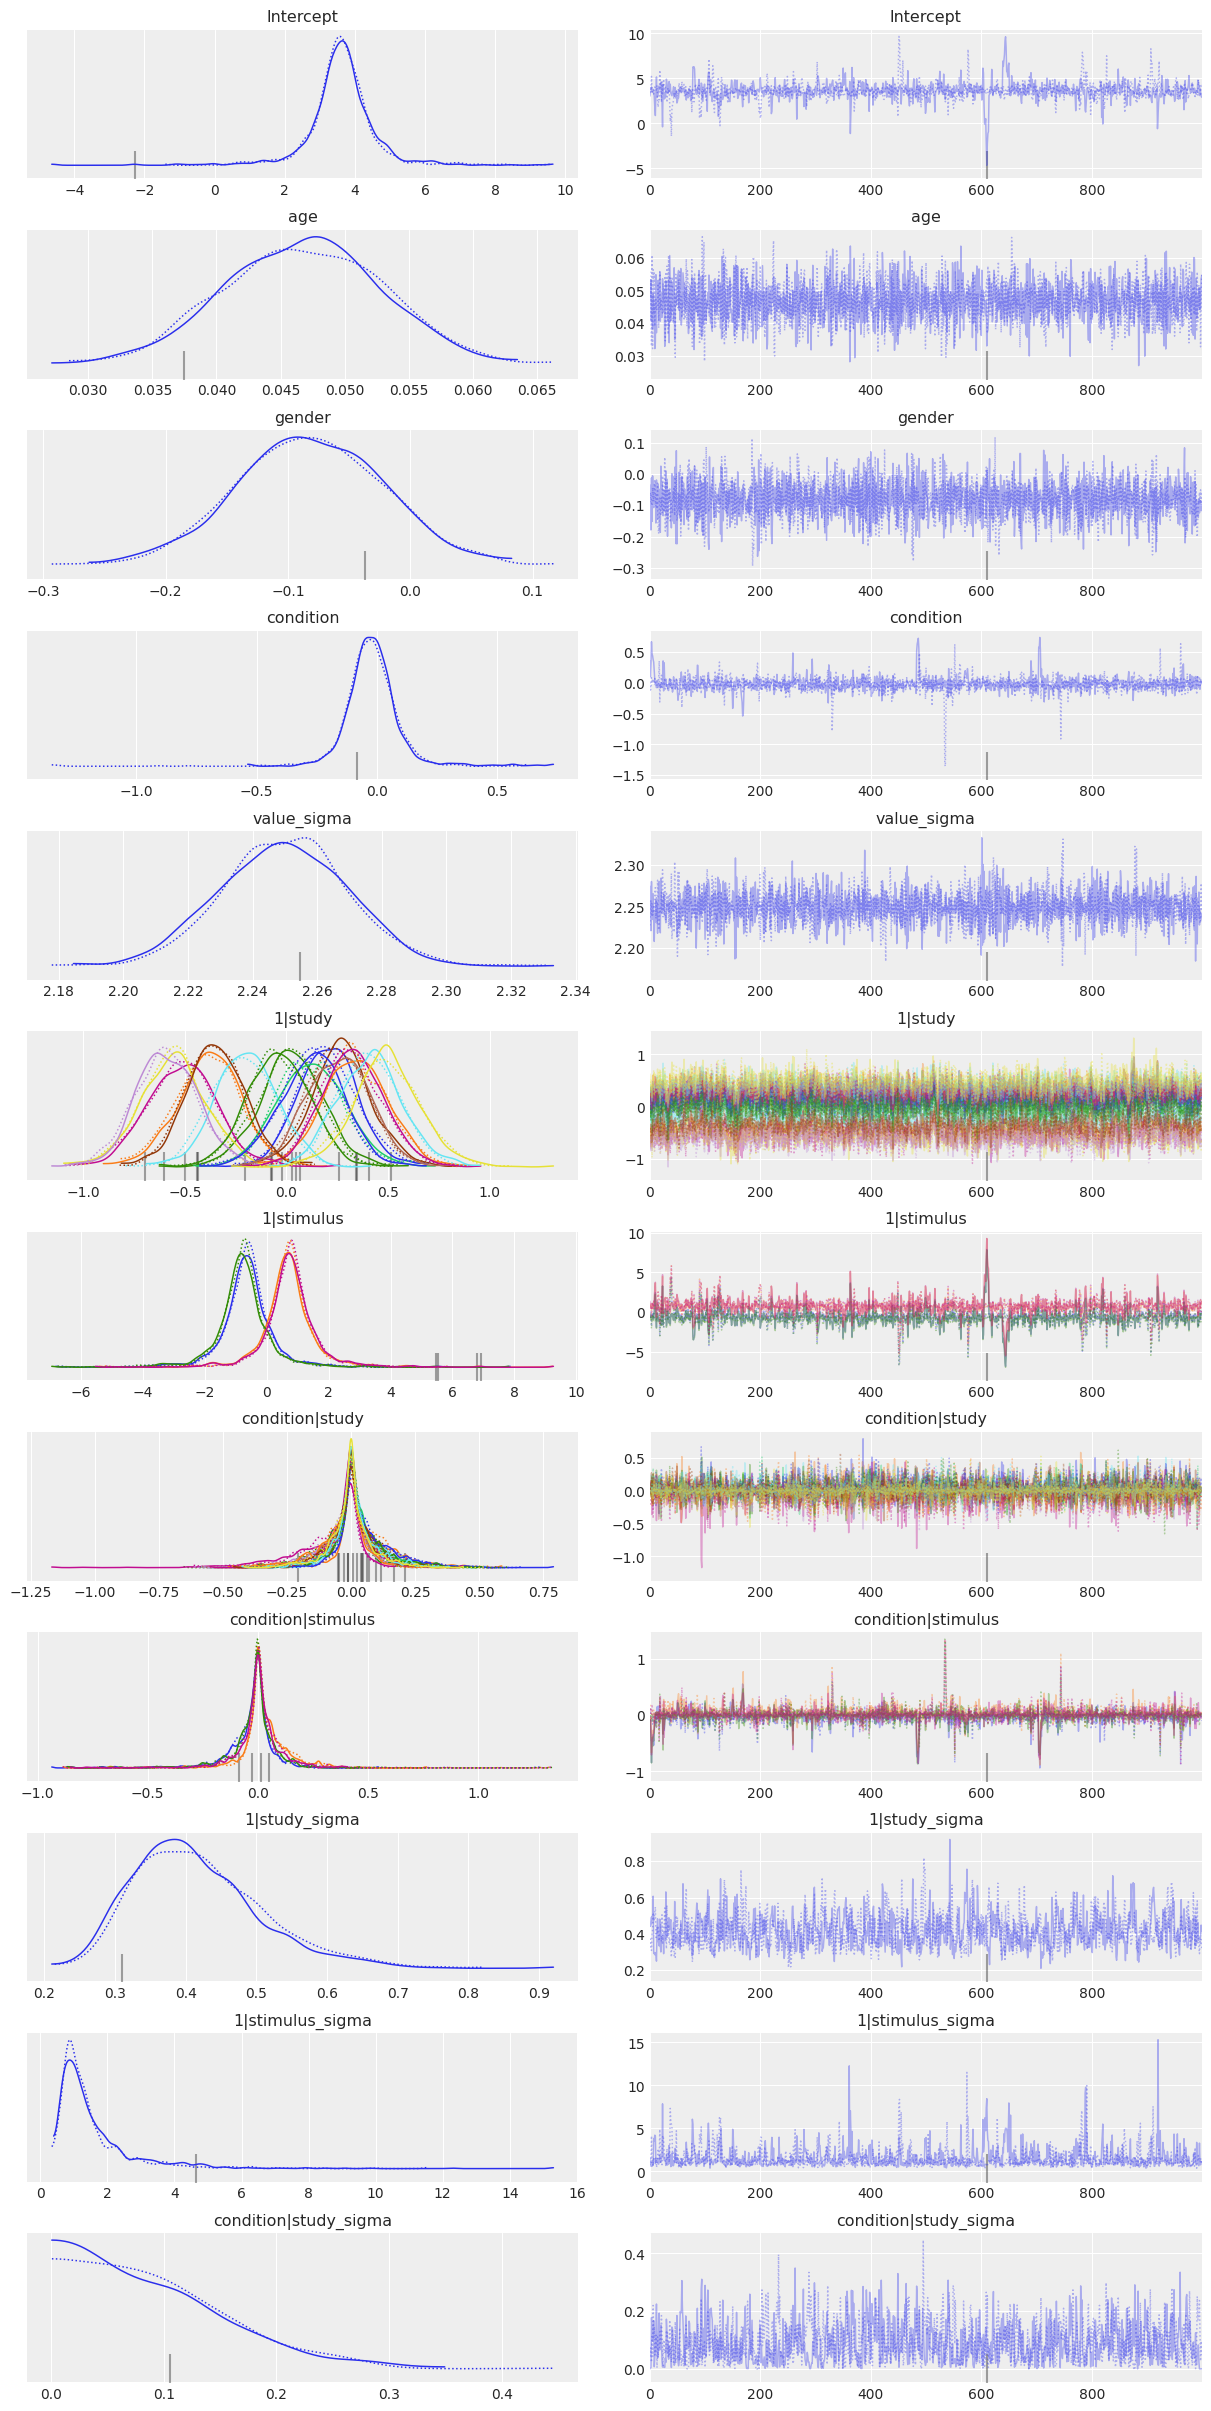

In [6]:
az.plot_trace(results,
              var_names=['Intercept', 'age', 'gender', 'condition', 'value_sigma',
                        '1|study', '1|stimulus', 'condition|study', 'condition|stimulus',
                        '1|study_sigma', '1|stimulus_sigma', 'condition|study_sigma',
                        ],
              compact=True);
plt.savefig("imgs/rrr_posterior.png")